# Genre Classification using BERT Embeddings
Please refer to research paper for details and clarifications.

## Motivations & Research Question

What I'm interested in learning is:

**Can sentence BERT embeddings used to classify genres between album rock, adult standards, alternative metal, alternative rock and dance pop?**

Embeddings, as described by Mikolov and colleagues in their foundational paper "Distributed Representations of Words and Phrases and their Compositionality," are defined as "dense vectors of floating point values" that are "derived from text data so that the vectors' spatial relationships encapsulate the connections between words" (Mikolov et al., 2013). The essence of embeddings is to capture not just the words themselves but also the semantic essence of sentences. This enables machines to understand text in a more sophisticated and insightful manner, which is crucial for applications like sentiment analysis, machine translation, and document clustering, as it allows for a deeper comprehension of the text beyond mere surface-level interpretation.

Exploring lyrical consistency, variety, and evolution within musical genres through this lens is pivotal. Examining lyrical resemblances across genres can unveil the progression of genre-specific themes, linguistic choices, and cultural references over time. Tsaptisinos (2017) employed a Hierarchical Attention Network model for music genre classification based on lyrics, highlighting that "Through the learning process, we can also visualize which words or lines in a song the model deems significant for genre classification"[1]. He posits that lyrical examination is fundamental for genre identification, with specific themes and linguistic selections acting as distinctive markers of a genre.

For researchers in the Music Information Retrieval (MIR) domain, analyzing lyrical similarities through embeddings is equally significant. Their main areas of focus include developing genre classification algorithms and recommendation systems, considering lyrics as a critical element alongside audio. Yu and associates crafted a deep learning solution that "incorporates temporal sequences to discern the interplay between audio and lyrics for facilitating audio-lyrics cross-modal music retrieval, wherein sequential audio and lyrics are transformed into a shared semantic space"[2]. This demonstrates the potential of utilizing lyrical textual content to enhance MIR systems.

Lyric similarities can also illuminate aspects of lyrical complexity. Varnum and colleagues noted in their study that "individuals might prefer songs with simpler lyrics...songs with more repetitive lyrics could have advantages in terms of information transmission since they are more memorable and can be conveyed more accurately. Moreover, recent findings suggest that simpler, more repetitive music is perceived as more enjoyable, engaging, and memorable by listeners"[3]. This might indicate that popular music genres favor simpler lyrics to align with listener preferences, potentially leading to increased lyrical similarity within these genres due to a tendency towards easy-to-remember hooks and phrases.

Thus, addressing this question is of considerable significance. To do so, we'll undertake a three-step process involving data loading & preprocessing, embedding generation, and analysis.

In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

torch.cuda.is_available()

C:\Users\danny\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


True

## About the Dataset

The dataset titled "57,650 Spotify Songs" is from Kaggle. It contains 57,651 rows and 4 columns, named 'artist', 'song', 'link', and 'text'. All columns are of string type. It offers a comprehensive collection of Spotify song data, including the artist's name, song title, a link to the song's lyrics, and the lyrics text itself. This dataset is designed for analysis and could be used in various projects related to music, lyrics analysis, and natural language processing tasks. Unfortunately the author of this dataset did not specify data extraction process (song selection criteria etc.), but it's safe to assume all the data are extracted from Spotify.

In addition, we are incorporating Spotify Developer API to pull more information about artist (such as genre) to enhance our analysis.

In [2]:
#loading dataset
spotify_csv = pd.read_csv('Spotify Million Song Dataset_exported.csv')
len(set(spotify_csv['artist']))

643

In [3]:
spotify_csv.drop('link', axis=1, inplace=True)
spotify_csv['text'] = spotify_csv['text'].str.lower().replace('\n', ' ', regex=True)
spotify_csv.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"look at her face, it's a wonderful face and ..."
1,ABBA,"Andante, Andante","take it easy with me, please touch me gently..."
2,ABBA,As Good As New,i'll never know why i had to go why i had to...
3,ABBA,Bang,making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,making somebody happy is a question of give an...


## Spotify API Data Retrieval

Due to the Kaggle dataset lacking genre information about each artist, we have to utilize Spotify Developer API to get genre information. Spotipy is a python library that can retrieve such information given an API key. The only thing we need to be aware here is Spotify has a 30-second API call limit that they don't disclose how much (but instead saying it's "dynamically capped"), so to be safe we cap the # of calls to not exceeding 60 per 30 seconds to avoid API Call error. 

The following two API code blocks simply retrieve genre information and store them to a new column.

In [4]:
# Authenticate with Spotify
client_credentials_manager = SpotifyClientCredentials(client_id='92d4c13d9daa4576aa351a8d23177621', client_secret='d2ed9c4c6010426e85d46e4d4f2e2e5e')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to get genres for an artist
def get_genres_for_artist(artist_name):
    results = sp.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        artist = items[0]
        return artist['genres']
    else:
        return []

In [5]:
from tqdm.notebook import tqdm
import time
import pandas as pd

def enrich_artist_data_batch(df):
    unique_artists = df['artist'].unique()
    artist_genre_map = {}
    
    # Initialize progress bar for unique artists
    pbar = tqdm(total=len(unique_artists))
    start_time = time.time()
    
    for i, artist_name in enumerate(unique_artists):
        # Rate limiting control for Spotify API calls
        if i % 60 == 0 and i != 0:
            end_time = time.time()
            elapsed_time = end_time - start_time
            if elapsed_time < 30:
                time.sleep(30 - elapsed_time)
            start_time = time.time()
        
        # API call to fetch artist data
        try:
            results = sp.search(q='artist:' + artist_name, type='artist')
            items = results['artists']['items']
            if items:
                artist = items[0]
                artist_genre_map[artist_name] = ', '.join(artist.get('genres', []))
        except Exception as e:
            print(f"Error fetching data for {artist_name}: {e}")
        
        pbar.update(1)  # Update progress bar
    
    pbar.close()
    
    # Map genres back to the original DataFrame
    df['Genre'] = df['artist'].map(artist_genre_map)
    
    return df

df_enriched = enrich_artist_data_batch(spotify_csv)

  0%|          | 0/643 [00:00<?, ?it/s]

## Embedding Generation

Here we are using a sentence transformer to convert all the lyrics into embeddings. Embeddings are dense vector representations of text, words, or other entities in a continuous vector space. These vectors capture semantic meanings, relationships, and properties of the entities they represent, allowing machines to understand and process language or other complex data types in a more human-like way. In the past word2vec was very popular for embedding generation but using transformers is a lot more advanced because word2vec only consider word individually without considering context (relationship with other words) but transformer is much more robust in considering the context when generating embeddings, so using sentence transformer is clearly a more modern and effective approach.

The model I'm using is called all-MiniLM-L12-v2. It's a fine-tuned sentence transformer base on 1B sentence pairs dataset. The initial objective was: "given a sentence from the pair, the model should predict which out of a set of randomly sampled other sentences, was actually paired with it in our dataset...Given an input text, it outputs a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks." which fits into our objective, to generate embeddings to discover lyrics similarities. 

The model is also a great candidate for this task because it's lightweight with great performance. Its non-finetuned base model, MiniLM-L12-H384-uncased by Microsoft, has only 33 million parameters with 12 layers yet it yields better (if not similar) performance than 109 million parameters BERT-base model (over 3 times larger in parameter size) in numerious metrics such as MNLI-m, CoLA, and RTE. The code is executed on a NVIDIA RTX 4090 GPU, and while the dataset has over 50k songs, it can finish the embedding generation tasks in under 5 minutes.



In [6]:
# Initialize the model
# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
def get_embeddings(texts, batch_size=32):
    """
    Generate embeddings for a list of texts using the loaded SBERT model in batches.
    """
    # Pre-allocate a list to hold the embeddings
    all_embeddings = []
    
    # Process texts in batches
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[start_index:start_index+batch_size]
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        all_embeddings.extend(batch_embeddings)
    
    return all_embeddings

# Generate embeddings for the 'text' column in batches
embeddings = get_embeddings(df_enriched['text'].tolist())

# Add embeddings to the DataFrame
df_enriched['embeddings'] = embeddings


C:\Users\danny\anaconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


  0%|          | 0/1802 [00:00<?, ?it/s]

## Genre Extraction

Pulling genre information from Spotify isn't the end, because Spotify API returns a list of very detailed genres, such as southern rap, indietronica. Good news is it's all separated by comma, so all we have to do is to split them by comma, then we group them together.

In [7]:
def keep_first_genre(genres):
    """
    Keeps only the first genre from the genre list.
    """
    if isinstance(genres, str):
        # Split genres by comma, clean up each genre string, and keep only the first one
        first_genre = genres.split(', ')[0].strip()
    else:
        # Handle non-string genre values (e.g., NaN or None)
        first_genre = "Unknown"  # This handles missing or invalid genre values
    return first_genre

# Apply the keep_first_genre function to transform the 'Genre' column to only keep the first genre
df_enriched['Genre'] = df_enriched['Genre'].apply(keep_first_genre)


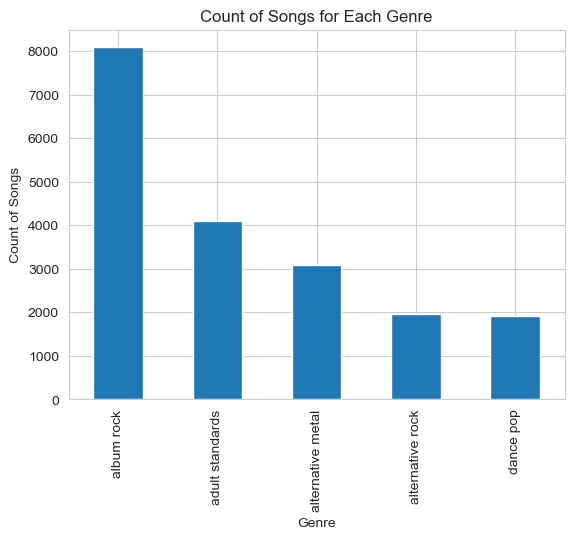

Genre
album rock           8085
adult standards      4099
alternative metal    3093
alternative rock     1960
dance pop            1911
Name: count, dtype: int64


In [8]:
# Count of songs for each genre
genre_count = df_enriched['Genre'].value_counts()[:5]

# Plotting
import matplotlib.pyplot as plt

genre_count.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count of Songs')
plt.title('Count of Songs for Each Genre')
plt.show()

# Keeping rows only within top 3 genres by count
print(genre_count.head(5))
top_5_genres = genre_count.head(5).index
df_enriched = df_enriched[df_enriched['Genre'].isin(top_5_genres)].reset_index(drop=True)
#album rock, adult standards, alternative metal, alternative rock, dance pop

In [9]:
df_enriched

,artist,song,text,Genre,embeddings
0,Aerosmith,All Your Love,all your love i miss lovin' all your kiss i ...,album rock,"[-0.06764981, 0.019830443, 0.08280114, 0.01749..."
1,Aerosmith,Bacon Biscuit Blues,"put your biscuits in the oven honey, put you...",album rock,"[-0.018376715, 0.022525674, 0.04651205, 0.0275..."
2,Aerosmith,Blind Man,i took a course in hallelujah i went to nigh...,album rock,"[-0.07508652, 0.03855812, 0.085562505, 0.05953..."
3,Aerosmith,Draw The Line,"checkmate honey, beat ya at your own damn game...",album rock,"[0.014436898, -0.05981798, 0.054028578, 0.0097..."
4,Aerosmith,Eat The Rich,well i woke up this morning on the wrong sid...,album rock,"[-0.035021123, -0.040596843, 0.063370496, 0.01..."
...,...,...,...,...,...
19143,Z-Ro,Talkin' Down On Me,"[z-ro] since i been out by myself, i keep th...",alternative metal,"[-0.04846199, -0.064648345, 0.002598857, 0.019..."
19144,Z-Ro,That'z Who I Am,"[z-ro] houston texas is my city, ridgemont 4...",alternative metal,"[-0.082574755, -0.08707365, -0.05827423, -0.00..."
19145,Z-Ro,To Love A Thug,"(talking) look out man, quit tripping man, h...",alternative metal,"[-0.00762702, -0.036338888, 0.015561868, 0.075..."
19146,Z-Ro,Uncut,(feat z-ro chamillonre and hype) [verse 1 - ...,alternative metal,"[-0.096062355, -0.0066575874, -0.031980228, -0..."


## Random Forest for Genre Classification

Random Forest is a bagging ensemble machine learning model aiming to classify genres using multiple decision trees. In this case, it's suitable because it has a degree of complexity, and we are trying to solve a multi-category classification problem.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
import pandas as pd

X = pd.DataFrame(df_enriched['embeddings'].tolist())
y = df_enriched['Genre']

# First, concatenate the features and the target variable back into one DataFrame
df_combined = pd.concat([pd.DataFrame(X), pd.Series(y, name='Genre')], axis=1)

# Finding the number of samples in the smallest class
min_count = df_combined['Genre'].value_counts().min()

# Create an empty DataFrame to hold the undersampled data
df_undersampled = pd.DataFrame()

# Undersample each class
for genre in df_combined['Genre'].unique():
    df_genre = df_combined[df_combined['Genre'] == genre]
    df_genre_undersampled = resample(df_genre, 
                                     replace=False,    # sample without replacement
                                     n_samples=min_count,     # to match minority class
                                     random_state=123) # so result is reproducible
    df_undersampled = pd.concat([df_undersampled, df_genre_undersampled])

# Now, separate the features and the target variable again
X_undersampled = df_undersampled.drop('Genre', axis=1).values
y_undersampled = df_undersampled['Genre'].values

# Split the undersampled data into training and testing sets
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(
    X_undersampled, y_undersampled, test_size=0.3, random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the undersampled data
grid_search.fit(X_train_undersampled, y_train_undersampled)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to predict genres for the test set
y_pred_undersampled = grid_search.predict(X_test_undersampled)

# Evaluate the model's performance on the undersampled dataset
accuracy_undersampled = accuracy_score(y_test_undersampled, y_pred_undersampled)
print(f"Accuracy (Undersampled): {accuracy_undersampled:.4f}")
print(classification_report(y_test_undersampled, y_pred_undersampled))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy (Undersampled): 0.4520
                   precision    recall  f1-score   support

  adult standards       0.55      0.56      0.56       608
       album rock       0.34      0.18      0.24       582
alternative metal       0.50      0.49      0.49       566
 alternative rock       0.37      0.47      0.42       544
        dance pop       0.46      0.56      0.50       567

         accuracy                           0.45      2867
        macro avg       0.44      0.45      0.44      2867
     weighted avg       0.45      0.45      0.44      2867


## Neural Network-based Classification

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

X = pd.DataFrame(df_enriched['embeddings'].tolist())
y = df_enriched['Genre']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Combine into a single DataFrame for easier handling
df_combined = pd.concat([X, pd.Series(y_encoded, name='Genre')], axis=1)

# Find the number of samples in the smallest class
min_count = df_combined['Genre'].value_counts().min()

# Create an empty DataFrame for the undersampled data
df_undersampled = pd.DataFrame()

# Undersample each class
for genre in df_combined['Genre'].unique():
    df_genre = df_combined[df_combined['Genre'] == genre]
    df_genre_undersampled = resample(df_genre, 
                                     replace=False,    # Sample without replacement
                                     n_samples=min_count,  # Match minority class size
                                     random_state=123)  # Ensure reproducibility
    df_undersampled = pd.concat([df_undersampled, df_genre_undersampled], ignore_index=True)

# Separate the features and the target variable again
X_undersampled = df_undersampled.drop('Genre', axis=1).values
y_undersampled = df_undersampled['Genre'].values

# Split the undersampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_undersampled, y_undersampled, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Define DataLoader parameters
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_encoded))
model = MLP(input_size, hidden_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 1000
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()  # Make sure model is in training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()  # Set the model to evaluation mode
y_pred = []
y_true = []
with torch.no_grad():  # Inference mode
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute classification report
print(classification_report(y_true, y_pred, target_names=[f'Class {x}' for x in np.unique(y_encoded)]))


Epochs: 100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s]


              precision    recall  f1-score   support

     Class 0       0.58      0.52      0.55       608
     Class 1       0.35      0.34      0.35       582
     Class 2       0.43      0.44      0.43       566
     Class 3       0.39      0.43      0.41       544
     Class 4       0.46      0.47      0.46       567

    accuracy                           0.44      2867
   macro avg       0.44      0.44      0.44      2867
weighted avg       0.44      0.44      0.44      2867


## Text Similarity Calculation

Cosine similarity is a common way to generate index for text similarities, we take two embedding vectors and we calculate the angle between two vectors, then we apply a cosine function onto the angle, since the cosine function yields any value between -1 and 1, higher the value more similar the lyrics would be. In other words, smaller the angle between the vectors, higher the similarity.


The result of cosine similarity ranges from -1 to 1.

- 
A value of 1 means the vectors are identical in orientation (i.e., the sentences are semantically very similar)
  .- 
A value of 0 indicates orthogonality (i.e., no similarity between the sentences
  )- .
A value of -1 means the vectors are diametrically opposed (i.e., the sentences are semantically opposite, which is less common in typical NLP applications).

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Group the DataFrame by artist and genre to aggregate embeddings into a list per artist and genre.
artist_embeddings = df_enriched.groupby('artist')['embeddings'].apply(list)
genre_embeddings = df_enriched.groupby('Genre')['embeddings'].apply(list)

# Function to calculate similarity scores
def calculate_similarity(embeddings_group):
    similarity_scores = {}
    for key, embeddings in tqdm(embeddings_group.items(), desc="Calculating similarities"):
        if len(embeddings) > 1:
            embeddings_matrix = np.array(embeddings)
            similarity_matrix = cosine_similarity(embeddings_matrix)
            # Averaging similarities across all pairs
            avg_similarity = np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
            similarity_scores[key] = avg_similarity
    return similarity_scores

# Calculate similarity scores
artist_similarity_scores = calculate_similarity(artist_embeddings)
genre_similarity_scores = calculate_similarity(genre_embeddings)

# Convert to DataFrame
artist_similarity_df = pd.DataFrame(artist_similarity_scores.items(), columns=['artist', 'Artist Similarity Score'])
genre_similarity_df = pd.DataFrame(genre_similarity_scores.items(), columns=['Genre', 'Genre Similarity Score'])

# Merge artist similarity into the main DataFrame
df_enriched = df_enriched.merge(artist_similarity_df, on='artist', how='left')

# Since genre similarity is on a genre level, we'll just map those values onto the original DataFrame
genre_similarity_map = genre_similarity_df.set_index('Genre')['Genre Similarity Score'].to_dict()
df_enriched['Genre Similarity Score'] = df_enriched['Genre'].map(genre_similarity_map)

Calculating similarities: 167it [00:00, 1159.50it/s]
Calculating similarities: 5it [00:00,  5.51it/s]


In [14]:
genres_to_keep = ['album rock', 'adult standards', 'alternative metal', 'alternative rock', 'dance pop']
# Filter the DataFrame
df_enriched = df_enriched.loc[df_enriched['Genre'].isin(genres_to_keep)]

In [15]:
df_enriched

,artist,song,text,Genre,embeddings,Artist Similarity Score,Genre Similarity Score
0,Aerosmith,All Your Love,all your love i miss lovin' all your kiss i ...,album rock,"[-0.06764981, 0.019830443, 0.08280114, 0.01749...",0.335399,0.292873
1,Aerosmith,Bacon Biscuit Blues,"put your biscuits in the oven honey, put you...",album rock,"[-0.018376715, 0.022525674, 0.04651205, 0.0275...",0.335399,0.292873
2,Aerosmith,Blind Man,i took a course in hallelujah i went to nigh...,album rock,"[-0.07508652, 0.03855812, 0.085562505, 0.05953...",0.335399,0.292873
3,Aerosmith,Draw The Line,"checkmate honey, beat ya at your own damn game...",album rock,"[0.014436898, -0.05981798, 0.054028578, 0.0097...",0.335399,0.292873
4,Aerosmith,Eat The Rich,well i woke up this morning on the wrong sid...,album rock,"[-0.035021123, -0.040596843, 0.063370496, 0.01...",0.335399,0.292873
...,...,...,...,...,...,...,...
19143,Z-Ro,Talkin' Down On Me,"[z-ro] since i been out by myself, i keep th...",alternative metal,"[-0.04846199, -0.064648345, 0.002598857, 0.019...",0.455479,0.274858
19144,Z-Ro,That'z Who I Am,"[z-ro] houston texas is my city, ridgemont 4...",alternative metal,"[-0.082574755, -0.08707365, -0.05827423, -0.00...",0.455479,0.274858
19145,Z-Ro,To Love A Thug,"(talking) look out man, quit tripping man, h...",alternative metal,"[-0.00762702, -0.036338888, 0.015561868, 0.075...",0.455479,0.274858
19146,Z-Ro,Uncut,(feat z-ro chamillonre and hype) [verse 1 - ...,alternative metal,"[-0.096062355, -0.0066575874, -0.031980228, -0...",0.455479,0.274858


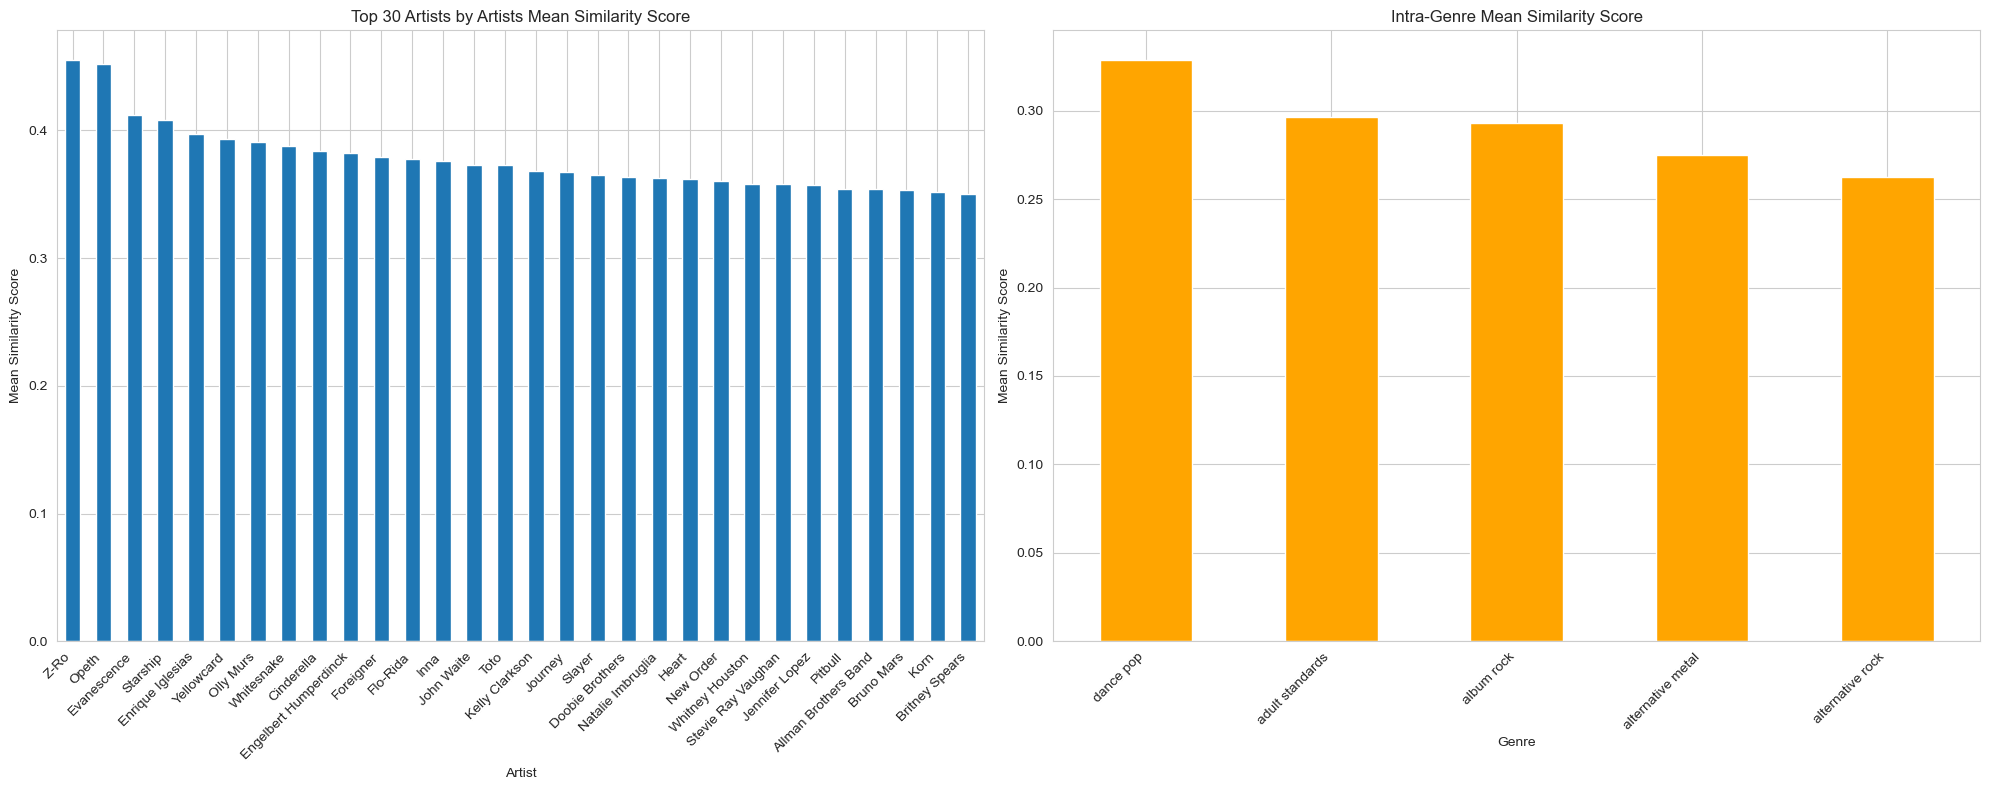

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate mean similarity score by artist and genre
artist_mean_similarity = df_enriched.groupby('artist')['Artist Similarity Score'].mean().reset_index()
genre_mean_similarity = df_enriched.groupby('Genre')['Genre Similarity Score'].mean().reset_index()

# Sort and take top 30 for each
top_artists = artist_mean_similarity.sort_values(by='Artist Similarity Score', ascending=False).head(30)
top_genres = genre_mean_similarity.sort_values(by='Genre Similarity Score', ascending=False).head(30)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Artist Similarity Score
top_artists.plot(kind='bar', x='artist', y='Artist Similarity Score', ax=axes[0], legend=None)
axes[0].set_title('Top 30 Artists by Artists Mean Similarity Score')
axes[0].set_xlabel('Artist')
axes[0].set_ylabel('Mean Similarity Score')
# Correctly rotate and align x-axis labels
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Genre Similarity Score
top_genres.plot(kind='bar', x='Genre', y='Genre Similarity Score', ax=axes[1], color='orange', legend=None)
axes[1].set_title('Intra-Genre Mean Similarity Score')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Mean Similarity Score')
# Correctly rotate and align x-axis labels
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


Here we can see observe the intra-genre similarity is very low within each genre, with the highest only slightly over 0.3. This indicates within each of the 5 genres songs are very diverse lyric wise.

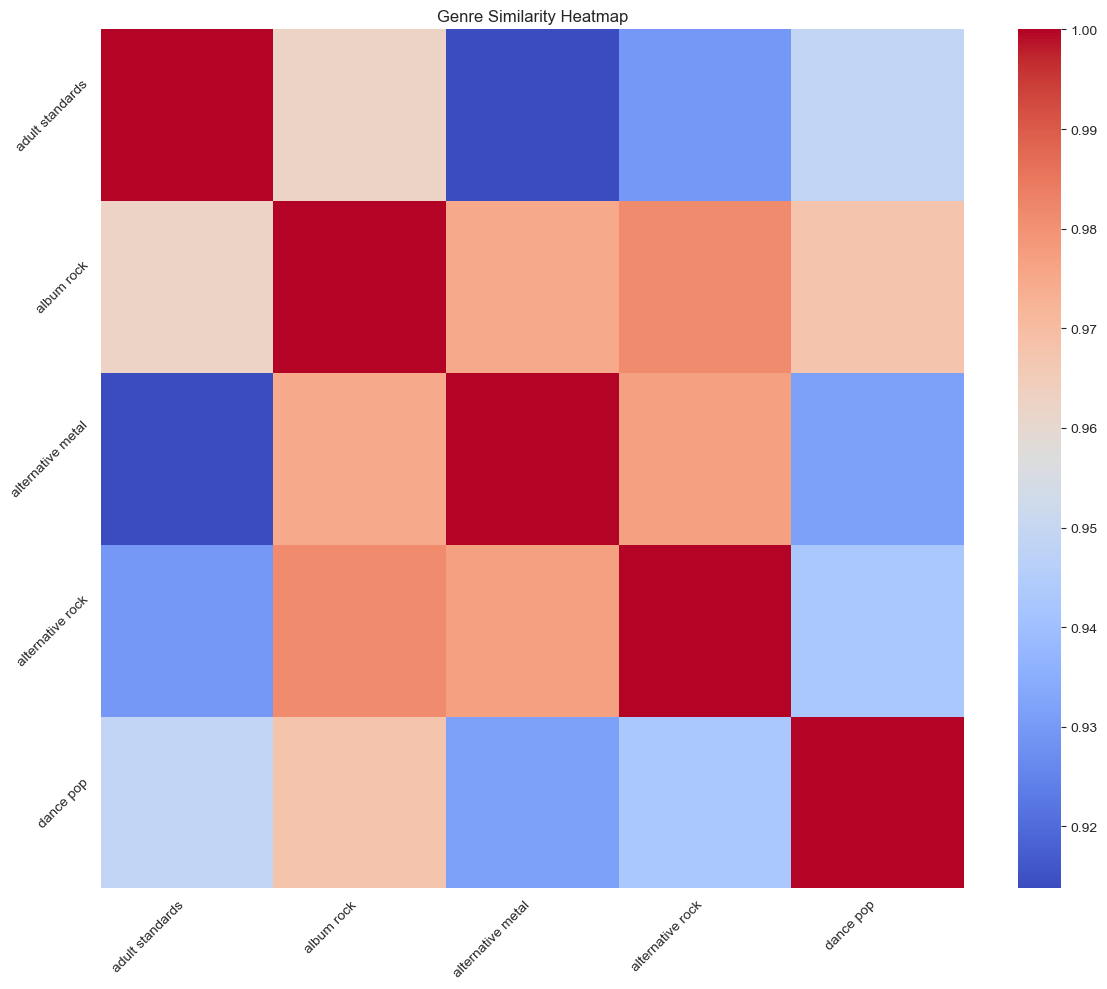

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy to avoid modifying the original DataFrame
df_copy = df_enriched.copy()

# Convert embeddings from string representations to numpy arrays
df_copy['embeddings'] = df_copy['embeddings'].apply(lambda x: np.array(x))

# Calculate the average embedding for each genre
genre_avg_embeddings = df_copy.groupby('Genre')['embeddings'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()

# Prepare the data for cosine similarity calculation
avg_embeddings = np.stack(genre_avg_embeddings['embeddings'].values)

# Calculate the cosine similarity between each pair of average genre embeddings
similarity_matrix = cosine_similarity(avg_embeddings)

# Convert the similarity matrix into a DataFrame for easier visualization
genre_labels = genre_avg_embeddings['Genre'].values
df_similarity = pd.DataFrame(similarity_matrix, columns=genre_labels, index=genre_labels)

# Plotting the similarity matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_similarity, annot=False, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Genre Similarity Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


Above is a heatmap for inter-genre music similarity, as you can see, they are surprising similar to each other. This combines with low intra-genre similarity are making the task extremely difficult. Even though the model performance is approximately 44%, it's still significantly better than random chance which is 20%. 

## Conclusion

In this project we have implemented random forest and multi-layer perceptron model on classifying 5 music genres using sentence-BERT genrated embeddings. While the accuracy is around 45% to 50% which doesn't look good, it's still an acceptable metric given it's still significantly better than random guessing which is 20%. Base on the previous two charts, we can get the reason behind the "low performance" which is low intra-genre similarity combined with high inter-genre similarity. 

To answer the research question: Sentence BERT embedding can deliver acceptable result when it comes to classifying genres between album rock, adult standards, alternative metal, alternative rock and dance pop. However, the result can be significantly improved if we are able to combine more music information such as artist information into the training data.